In [1]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
#helper function to make sense of excel serial date format
import datetime

def xldate_to_datetime(xldate):
    temp = datetime.datetime(1900, 1, 1)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

In [3]:
#which quantile bin does the days return fall into?
#plot a histogram of each bin
centroids = pd.read_csv('/Users/livingdharma/Downloads/ProgrammingTest/spxFwdRetHistQCentroids.csv')

In [4]:
centroids['3'].value_counts()

9     2453
2     2426
7     2345
8     2310
3     2308
4     2296
5     2293
6     2216
1     1926
10    1921
Name: 3, dtype: int64

In [5]:
#io
fls1 = glob.glob('/Users/livingdharma/Downloads/ProgrammingTest/*.txt')
fls2= glob.glob('/Users/livingdharma/Downloads/ProgrammingTest/*.TXT')
fls_all = fls1[:1] + fls2[:5] + fls2[6:]

In [13]:
#construct feature matrix
#two data sources have been excluded for initial analysis

def construct_feature_matrix(fls_all):
    '''
    Constructs a feature matrix after some data cleaning
    '''
    dfs = []
    for fl in fls_all:
        df = pd.read_csv(fl)
        col_name = df.columns[1]
        df['date'] = df['Lookup'].apply(xldate_to_datetime)
        df = df.drop('Lookup', axis=1)
        df = df.set_index(keys='date')
        dfs.append(df)

    feature_matrix = pd.concat([df for df in dfs], join='inner', axis=1)
    feature_matrix = feature_matrix.dropna()
    
    return feature_matrix




In [7]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

def fit_model(X_train, y_train):
    '''
    
    '''
    model = linear_model.LogisticRegression()
    model.fit(X_train, np.sign(y_train))
    
    return model


In [8]:
def evaluate_model(model, X_test, y_test, ret):
    '''
    
    '''
    comparison = pd.DataFrame(y_test)
    comparison.rename(columns={ret: 'returns'}, inplace=True)
    comparison['prediction'] = model.predict(X_test)
    comparison['strategy'] = comparison['prediction'] * comparison['returns']
    
    return comparison 
    
    

In [9]:
def clean_target(path):
    targets = pd.read_csv(path)
    targets['date'] = targets['Lookup'].apply(xldate_to_datetime)
    targets = targets.set_index(keys='date').drop('Lookup', axis=1).dropna()
    return targets

In [14]:
#run some ml stuff
#check the 'goodness' of the model
#normalize the columns, rerun and evaluate
#add in other columns and rerun, evaluate
#add in other columns normalize, rerun, evaluate
#feature engineer the columns

feature_matrix = construct_feature_matrix(fls_all)
features = feature_matrix.columns
targets = clean_target('/Users/livingdharma/Downloads/ProgrammingTest/SpxFwdPct_Data.csv')
features_targets = pd.concat([feature_matrix, targets], join='inner', axis = 1)
features_targets = features_targets.dropna(axis=0)
split = int(len(features_targets) * .8)
# ###########

# for i, rtrn in enumerate(['3', '10', '21']):
#     X_train = features_targets[features][:split]
#     y_train = features_targets[rtrn][:split]
#     X_test = features_targets[features][split:]
#     y_test = features_targets[rtrn][split:]
#     model = fit_model(X_train, np.sign(y_train))
#     comparison = evaluate_model(model, X_test, y_test, rtrn)
    
    
#     hits = np.sign(comparison['returns'] *
#                         comparison['prediction']).value_counts()
    
#     acc_rate = hits.values[0] / sum(hits)
    
    
#     ax = comparison[['returns', 'strategy']].dropna().cumsum(
#                 ).apply(np.exp).plot(figsize=(10, 6))
    
#     ax.set_title('Accuracy Rate {} days Return = {:.2f}'.format(rtrn, acc_rate)) 

In [472]:
#What would a kind of backtest look like
# strategy = lr_model.predict(feature_matrix_3_16[cols])
# comparison = pd.DataFrame(feature_matrix_3_16_wrtns['10'])
# comparison.rename(columns={'10': 'returns'}, inplace=True)
# comparison['prediction'] = np.sign(strategy)
comparison['strategy'] = comparison['prediction'] * comparison['returns']

In [ ]:
#So I need to think about this quite a bit but my general thoughts are this
#we can do this linear return  ml thing with the deep learning thing just to demonstrate we can use tensorflow
#We can also change the outcome variable to see how it performs
#we can then use the returns themselves as columns

#i'd like to see what happens when we just do the sign of the previous day's return

#we've also got to do some cross-validation of these models or something to say, hey how much bullshit is this?


#lets test a bunch of models first in a pipeline to see where it gets us

In [110]:
feature_matrix = construct_feature_matrix(fls_all)
features = feature_matrix.columns
targets = clean_target('/Users/livingdharma/Downloads/ProgrammingTest/SpxFwdPct_Data.csv')
features_targets = pd.concat([feature_matrix, targets], join='inner', axis = 1)
features_targets = features_targets.dropna(axis=0)
split = int(len(features_targets) * .6)

In [168]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#model imports 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.model_selection import TimeSeriesSplit

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BernoulliNB(),
    LinearDiscriminantAnalysis(),
    ]

# Logging for Visual Comparison
log_cols=["Day", "Classifier", "Fold", "Accuracy", "Precision", "Recall", "F1"]
log = pd.DataFrame(columns=log_cols)

for day in ["3", "10", "21"]:
    
    for clf in classifiers:
        
        tscv = TimeSeriesSplit(n_splits=10)
        fold = 1
        for train_index, test_index in tscv.split(features_targets[features]):
            #print(test_index)
            X_train = features_targets[features][:train_index[-1]]
            y_train = features_targets[day][:train_index[-1]]
            X_test = features_targets[features][train_index[-1]:]
            y_test = features_targets[day][train_index[-1]:]



            clf.fit(X_train, np.sign(y_train))
            name = clf.__class__.__name__

            train_predictions = clf.predict(X_test)
            acc = accuracy_score(np.sign(y_test.values), train_predictions)


            precision = precision_score(np.sign(y_test.values), train_predictions, average='micro')
            recall = recall_score(np.sign(y_test.values), train_predictions, average='micro')
            f1 = f1_score(np.sign(y_test.values), train_predictions, average='micro')
    


            log_entry = pd.DataFrame([[day, name, fold, acc*100, precision, recall, f1]], columns=log_cols)
            log_entry = log_entry.set_index(keys='Classifier')
            log = log.append(log_entry)
            fold += 1

log = log.dropna(axis=1)

/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [173]:
log.to_csv('model_day_walk_forward_cross_val.csv')
log.groupby([log.index, 'Day']).mean()

Accuracy        F1  Precision    Recall
                           Day                                          
AdaBoostClassifier         10   53.364865  0.533649   0.533649  0.533649
                           21   57.104701  0.571047   0.571047  0.571047
                           3    53.944130  0.539441   0.539441  0.539441
BernoulliNB                10   52.670231  0.526702   0.526702  0.526702
                           21   55.106813  0.551068   0.551068  0.551068
                           3    51.851131  0.518511   0.518511  0.518511
GradientBoostingClassifier 10   53.944875  0.539449   0.539449  0.539449
                           21   57.378482  0.573785   0.573785  0.573785
                           3    53.231910  0.532319   0.532319  0.532319
KNeighborsClassifier       10   52.914136  0.529141   0.529141  0.529141
                           21   55.361577  0.553616   0.553616  0.553616
                           3    50.855052  0.508551   0.508551  0.508551
LinearDiscriminantAnalysis 10   54.496273  0.544963   0.544963  0.544963
                           21   58.058011  0.580580   0.580580  0.580580
                           3    54.595062  0.545951   0.545951  0.545951
LogisticRegression         10   57.908744  0.579087   0.579087  0.579087
                           21   61.456232  0.614562   0.614562  0.614562
                           3    55.938741  0.559387   0.559387  0.559387
RandomForestClassifier     10   51.111463  0.511115   0.511115  0.511115
                           21   54.450112  0.544501   0.544501  0.544501
                           3    50.434096  0.504341   0.504341  0.504341
SVC                        10   59.225390  0.592254   0.592254  0.592254
                           21   63.264335  0.632643   0.632643  0.632643
                           3    57.075306  0.570753   0.570753  0.570753

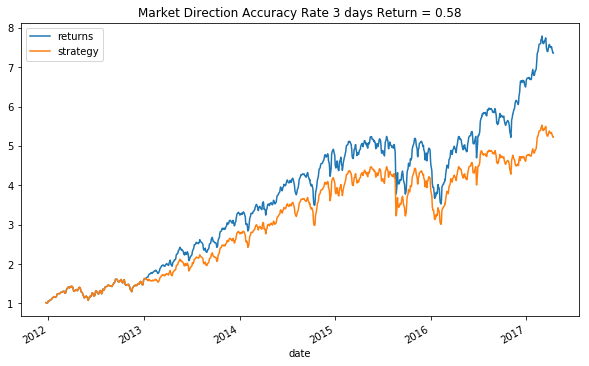

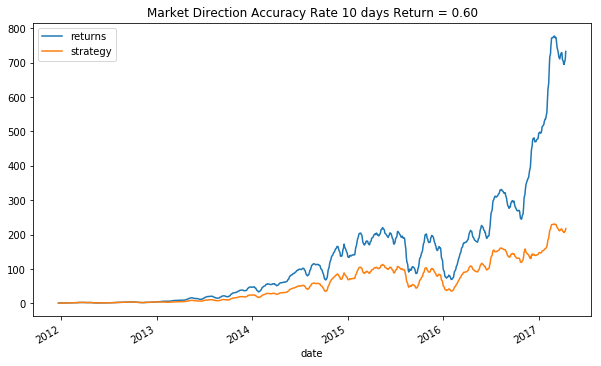

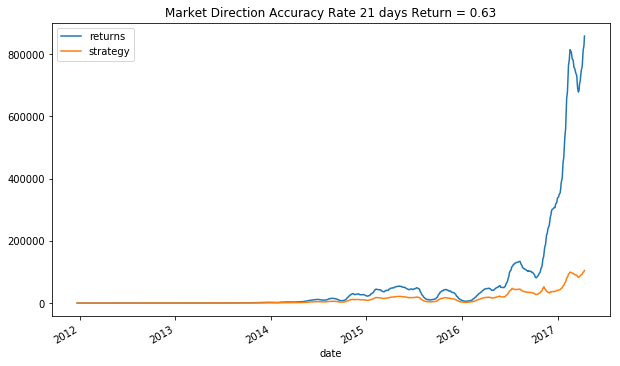

In [572]:
for i, rtrn in enumerate(['3', '10', '21']):
    X_train = features_targets[features][:split]
    y_train = features_targets[rtrn][:split]
    X_test = features_targets[features][split:]
    y_test = features_targets[rtrn][split:]
    model = fit_model(X_train, y_train)
    comparison = evaluate_model(model, X_test, y_test, rtrn)
    
    
    hits = np.sign(comparison['returns'] *
                        comparison['prediction']).value_counts()
    
    acc_rate = hits.values[0] / sum(hits)
    
    
    ax = comparison[['returns', 'strategy']].dropna().cumsum(
                ).apply(np.exp).plot(figsize=(10, 6))
    
    ax.set_title('Market Direction Accuracy Rate {} days Return = {:.2f}'.format(rtrn, acc_rate)) 